In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [3]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [4]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [5]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]])>

In [6]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [7]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1382.452392578125
mean: 7.355869770050049 loss: 491.21490478515625
mean: 8.901952743530273 loss: 192.91543579101562
mean: 9.662483215332031 loss: 135.6775360107422
mean: 9.929889678955078 loss: 129.76629638671875
mean: 9.994834899902344 loss: 129.46324157714844
mean: 10.005101203918457 loss: 129.45651245117188
mean: 10.00598430633545 loss: 129.4564666748047
mean: 10.005997657775879 loss: 129.45648193359375
mean: 10.005997657775879 loss: 129.45648193359375


In [9]:
sampling_mean

tensor(10.)

In [10]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(129.4583)
Likelihood in the optimized distribution:  tensor(129.4565, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [12]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [13]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [14]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[10.]])
sigma: tensor([[[4.]]], grad_fn=<IndexBackward0>)>

In [15]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0151)


In [16]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1740.7802734375
std: 1.4896724224090576 loss: 1553.0281982421875
std: 1.0747566223144531 loss: 1437.242919921875
std: 1.0110114812850952 loss: 1433.5181884765625
std: 1.0147432088851929 loss: 1433.502197265625
std: 1.0146892070770264 loss: 1433.502197265625
std: 1.014668583869934 loss: 1433.5020751953125
std: 1.014670491218567 loss: 1433.501953125
std: 1.014670491218567 loss: 1433.501953125
std: 1.014670491218567 loss: 1433.501953125


In [17]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1433.7163)
Likelihood in the optimized distribution:  tensor(1433.5020, grad_fn=<NegBackward0>)


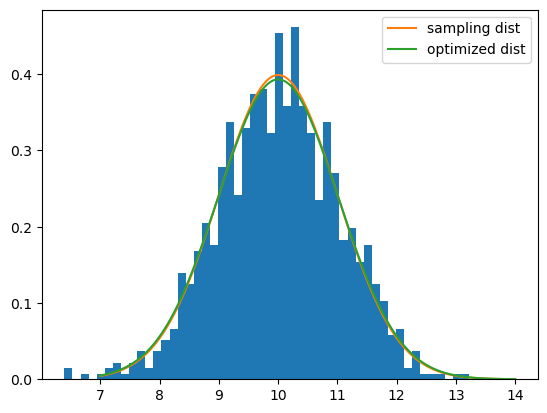

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [19]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [20]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [21]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [22]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [23]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[1.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]], grad_fn=<IndexBackward0>)>

In [24]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [25]:
torch.var(samples)

tensor(3.7891)

In [26]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [27]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3351.916748046875
par1: 1.4062180519104004 loss: 2324.570556640625
par1: 1.6081644296646118 loss: 2163.370849609375
par1: 1.730619192123413 loss: 2115.822265625
par1: 1.8122953176498413 loss: 2097.864501953125
par1: 1.868170976638794 loss: 2090.49365234375
par1: 1.9064598083496094 loss: 2087.3935546875
par1: 1.9324159622192383 loss: 2086.098876953125
par1: 1.949680209159851 loss: 2085.572998046875
par1: 1.9608789682388306 loss: 2085.3681640625


In [28]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2085.4426)
Likelihood in the optimized distribution:  tensor(2085.2925, grad_fn=<NegBackward0>)


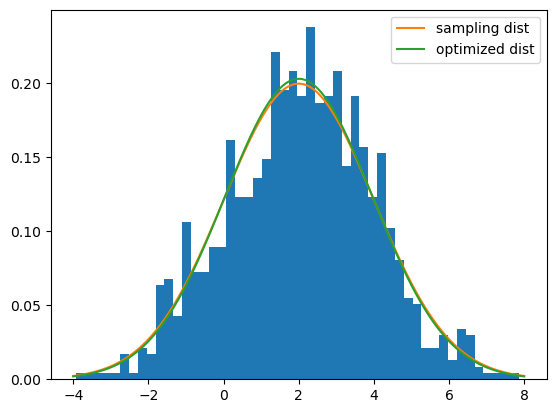

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [30]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [31]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [32]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [33]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [34]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[4.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[4.]]])>

In [35]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [36]:
torch.var(samples)

tensor(4.2132)

In [37]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2256.391845703125
par2: 1.949331283569336 loss: 2244.62255859375
par2: 1.9008374214172363 loss: 2233.72509765625
par2: 1.8536654710769653 loss: 2223.68896484375
par2: 1.807830572128296 loss: 2214.470703125
par2: 1.7633471488952637 loss: 2206.02685546875
par2: 1.7202279567718506 loss: 2198.314697265625
par2: 1.6784864664077759 loss: 2191.291748046875
par2: 1.638135313987732 loss: 2184.91748046875
par2: 1.5991864204406738 loss: 2179.15087890625


In [38]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2138.3071)
Likelihood in the optimized distribution:  tensor(2173.9529, grad_fn=<NegBackward0>)


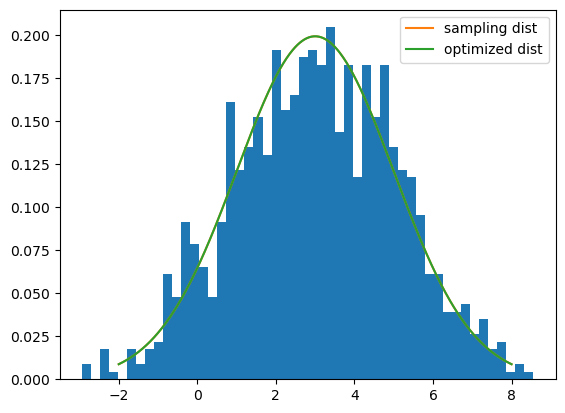

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [40]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *


In [41]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [42]:
cfg.node_list

{'entry': EntryNode<>,
 'test0': TestNode<test0,gm([1.],[_mean],[1.])<0>,
 'state0': StateNode<state0,True,a=gm([1.],[-5.],[1.])>,
 'state1': StateNode<state1,False,a=gm([1.],[5.],[1.])>,
 'merge0': MergeNode<merge0>,
 'exit': ExitNode<>}

In [43]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [44]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [45]:
output_dist

Dist<['a'],pi: tensor([[0.3085],
        [0.6915]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [46]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

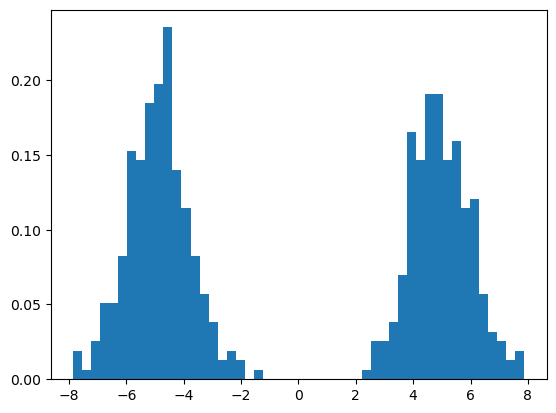

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [48]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [49]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)

    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1129.16357421875
mean: 0.2103770673274994 loss: 1093.9114990234375
mean: 0.03130533918738365 loss: 1084.4637451171875
mean: -0.031175293028354645 loss: 1083.6812744140625
mean: -0.03760668635368347 loss: 1083.6788330078125
mean: -0.03536940738558769 loss: 1083.6778564453125
mean: -0.03498529642820358 loss: 1083.677734375
mean: -0.03509895130991936 loss: 1083.677734375
mean: -0.035104863345623016 loss: 1083.6778564453125
mean: -0.03509915992617607 loss: 1083.677734375


In [50]:
current_dist

Dist<['a'],pi: tensor([[0.5140],
        [0.4860]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [51]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1083.8738)
Likelihood in the optimized distribution:  tensor(1083.6777, grad_fn=<NegBackward0>)


In [52]:
output_dist

Dist<['a'],pi: tensor([[0.5140],
        [0.4860]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

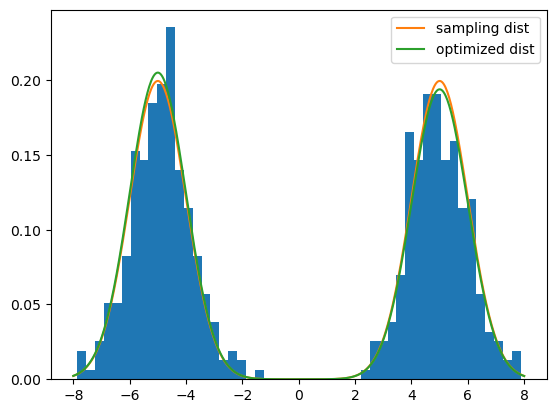

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [54]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [55]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [56]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [57]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [58]:
output_dist

Dist<['a'],pi: tensor([[0.6915],
        [0.3085]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [59]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

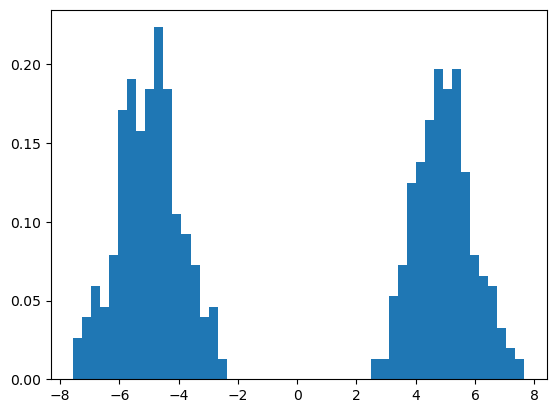

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [61]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1092.72998046875
coeff: 0.216828390955925 loss: 1066.9171142578125
coeff: 0.07641594856977463 loss: 1062.9315185546875
coeff: 0.05883049964904785 loss: 1062.9102783203125
coeff: 0.06522507965564728 loss: 1062.9033203125
coeff: 0.06547532975673676 loss: 1062.9033203125
coeff: 0.06516236066818237 loss: 1062.9031982421875
coeff: 0.06522350013256073 loss: 1062.9033203125
coeff: 0.06521914899349213 loss: 1062.9033203125
coeff: 0.06521813571453094 loss: 1062.9031982421875


In [62]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1063.5796)
Likelihood in the optimized distribution:  tensor(1062.9033, grad_fn=<NegBackward0>)


In [63]:
output_dist

Dist<['a'],pi: tensor([[0.5260],
        [0.4740]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

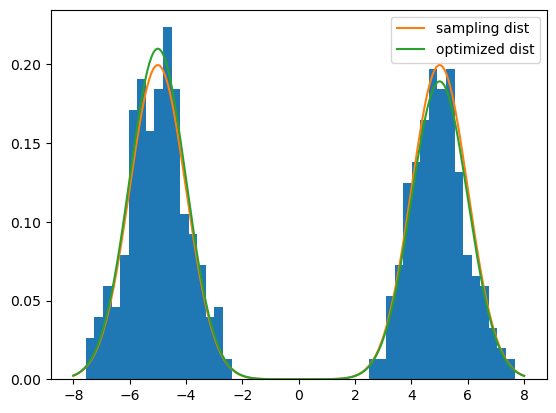

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [65]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [66]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [67]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [68]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [69]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[6.2500]]], grad_fn=<IndexBackward0>)>

In [70]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0369)


In [71]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3901.072998046875
mean: 5.880585193634033std: 3.220811367034912 loss: 2952.18896484375
mean: 6.5695013999938965std: 3.4480268955230713 loss: 2691.482177734375
mean: 7.200753211975098std: 3.391301155090332 loss: 2523.03125
mean: 7.825681686401367std: 3.0982701778411865 loss: 2348.27001953125
mean: 8.484480857849121std: 2.5604429244995117 loss: 2113.3115234375
mean: 9.225156784057617std: 1.7372562885284424 loss: 1746.800048828125
mean: 9.910077095031738std: 1.035430669784546 loss: 1456.83154296875
mean: 9.975112915039062std: 1.0363432168960571 loss: 1454.6820068359375
mean: 9.97482967376709std: 1.0363892316818237 loss: 1454.6820068359375


In [72]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1456.3073)
Likelihood in the optimized distribution:  tensor(1454.6820, grad_fn=<NegBackward0>)


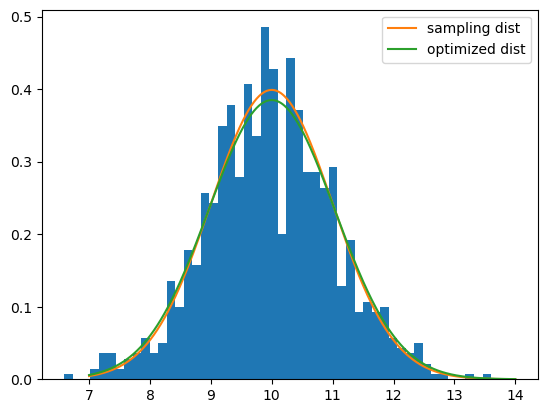

In [73]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(7,14,500).view(-1,1)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

## Optimization + Smoothing

### TEST 8

``` 
x = bern(0.5);
if x < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [22]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *

torch.set_default_dtype(torch.float64)

In [23]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim8.soga')
cfg = produce_cfg(compiledFile)

In [24]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [25]:
output_dist = start_SOGA_smooth(cfg, params_dict)

In [26]:
output_dist

Dist<['x', 'a'],pi: tensor([[0.5000],
        [0.5000]], grad_fn=<DivBackward0>)
mu: tensor([[ 0., -5.],
        [ 1.,  5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.0000e-10, 0.0000e+00],
         [0.0000e+00, 1.0000e+00]],

        [[1.0000e-10, 0.0000e+00],
         [0.0000e+00, 1.0000e+00]]], grad_fn=<IndexBackward0>)>

In [27]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

loss = neg_likelihood(current_dist, samples, 1)

In [28]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

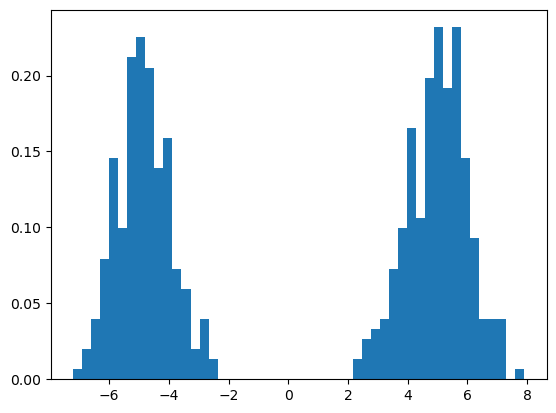

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [31]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA_smooth(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples, idx=1)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)

# E' normale che non ottimizzi perche' ogni valore in (0,1) va bene

coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436
coeff: 0.5 loss: 1039.9029619264436


In [ ]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1061.8419)
Likelihood in the optimized distribution:  tensor(1061.6459, grad_fn=<NegBackward0>)


In [ ]:
output_dist

Dist<['a'],pi: tensor([[0.5140],
        [0.4860]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

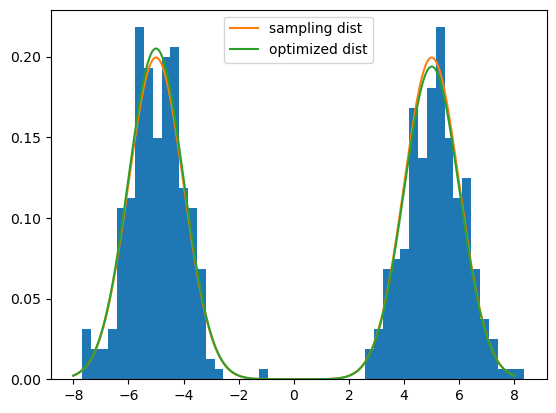

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

# Runtimes on old benchmarks

In [ ]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills5.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.04083165884017945

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills10.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.059299399852752684

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills20.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.19232213258743286

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills30.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.2792282724380493

In [ ]:
compiledFile=compile2SOGA('../programs/SOGA/Scalability/TrueSkills50.soga')
cfg = produce_cfg(compiledFile)

times = []

for i in range(100):
    start = time()
    output_dist = start_SOGA(cfg, {})
    end = time()
    times.append(end-start)

np.mean(times)

0.33835127830505374